In [ ]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import seaborn as sns
from google.colab import drive
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import graphviz
from google.cloud import bigquery
import pandas as pd

In [ ]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Lendo notas

In [ ]:
#file_name = "Cr_BSI"
#file_name = "CrMat"
file_name = "CrEngProd"
data_cr = pd.read_excel("/content/gdrive/My Drive/dados_mestrado/"+file_name+".xlsx")


In [ ]:
data_cr

,ID_PESSOA,NOME_PESSOA,ID_ALUNO,MATR_ALUNO,NUM_VERSAO,NOME_CURSO,COD_CURSO,ID_VERSAO_CURSO,ANO,COD_ATIV_CURRIC,...,CH_PRATICA,TOTAL_CARGA_HORARIA,CARGA_CURSO,DESCR_FORMA_INGRESSO,ANO_INGRESSO,DESCR_FORMA_EVASAO,ANO_EVASAO,SEXO,CR_NO_PERIODO,CR_ATUAL
0,56409,Alberto Gomes da Silva,52777,20101220001,2010-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,420,2010,TME0007,...,NaN,60,3840,EN - ENEM,2010,ABA - Abandono do curso,2011.0,M,2.43,2.4380
1,56409,Alberto Gomes da Silva,52777,20101220001,2010-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,420,2010,TEP0001,...,NaN,60,3840,EN - ENEM,2010,ABA - Abandono do curso,2011.0,M,2.43,2.4380
2,56409,Alberto Gomes da Silva,52777,20101220001,2010-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,420,2010,TEP0045,...,NaN,60,3840,EN - ENEM,2010,ABA - Abandono do curso,2011.0,M,2.43,2.4380
3,56409,Alberto Gomes da Silva,52777,20101220001,2010-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,420,2010,HFC0016,...,NaN,60,3840,EN - ENEM,2010,ABA - Abandono do curso,2011.0,M,2.43,2.4380
4,56409,Alberto Gomes da Silva,52777,20101220001,2010-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,420,2010,TEP0006,...,NaN,30,3840,EN - ENEM,2010,ABA - Abandono do curso,2011.0,M,2.43,2.4380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24829,170072,PATRICIA FRANCO PEREIRA,145366,20232220019,2018-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,658,2023,SCN0135,...,NaN,30,3770,SISU Ampla Concorrencia,2023,Sem evasão,NaN,F,0.70,0.7058
24830,170072,PATRICIA FRANCO PEREIRA,145366,20232220019,2018-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,658,2023,SCN0136,...,NaN,30,3770,SISU Ampla Concorrencia,2023,Sem evasão,NaN,F,0.70,0.7058
24831,169302,IÑIGO GARCIA-MOYA PEREZ,144663,20232220301,2018-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,658,2023,TEP0083,...,NaN,60,3770,AE - Mobilidade Acadêmica IAE/IESCE,2023,APO -Conclusão da Mobilidade Acadêmica Externa...,2024.0,M,8.57,8.5727
24832,169302,IÑIGO GARCIA-MOYA PEREZ,144663,20232220301,2018-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,658,2023,TEP0078,...,NaN,60,3770,AE - Mobilidade Acadêmica IAE/IESCE,2023,APO -Conclusão da Mobilidade Acadêmica Externa...,2024.0,M,8.57,8.5727


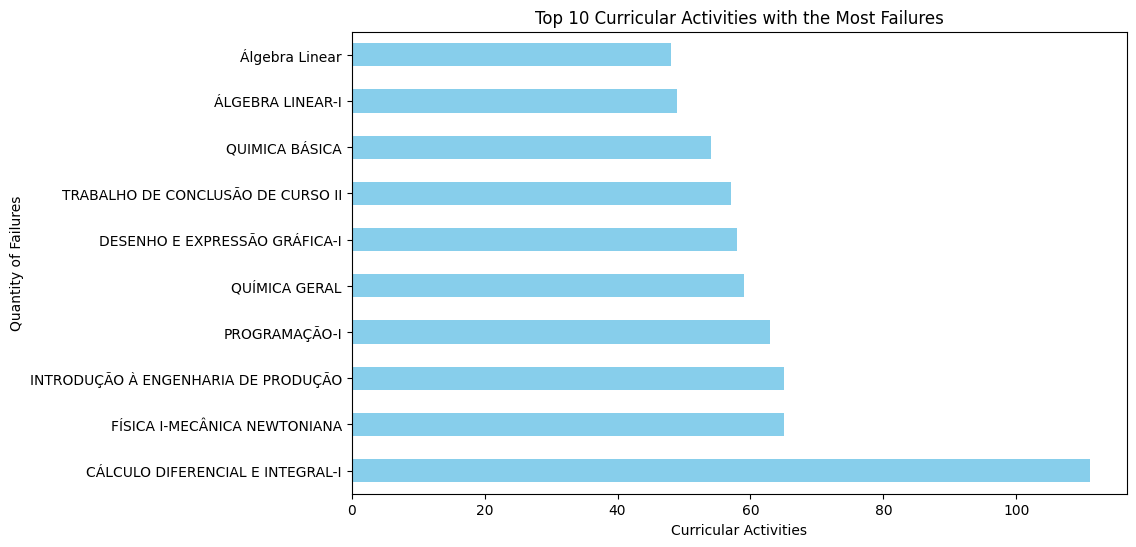

In [ ]:
import matplotlib.pyplot as plt

reprovados = data_cr [data_cr ['DESCR_SITUACAO'] == 'REP - Reprovado por nota/conceito']

# Calcular a contagem de reprovações para cada atividade curricular
reprovacao_counts = reprovados['NOME_ATIV_CURRIC'].value_counts()

# Pegar as 5 atividades com mais reprovações
top_5_reprovacoes = reprovacao_counts.head(10)

# Crie um gráfico de barras para as 5 atividades curriculares com mais reprovações
plt.figure(figsize=(10, 6))
top_5_reprovacoes.plot(kind='barh', color='skyblue')
plt.xlabel('Curricular Activities')
plt.ylabel('Quantity of Failures')
plt.title('Top 10 Curricular Activities with the Most Failures')
plt.show()

In [ ]:
print(data_cr['MEDIA_FINAL'].max())


10.0


In [ ]:
def get_gpa_values(series, n=4):
    unique_values = series.unique()
    return np.pad(unique_values, (0, max(0, n - len(unique_values))), constant_values=np.nan)[:n]

# Aplicar a função get_gpa_values para cada grupo de NOME_PESSOA
gpa_values = data_cr.groupby('NOME_PESSOA')['CR_NO_PERIODO'].apply(get_gpa_values).apply(pd.Series)

# Renomear as colunas
gpa_values.columns = ['GPA1', 'GPA2', 'GPA3', 'GPA4']

# Unir as novas colunas ao DataFrame original
data_cr = data_cr.merge(gpa_values, left_on='NOME_PESSOA', right_index=True)

data_cr.head()

,ID_PESSOA,NOME_PESSOA,ID_ALUNO,MATR_ALUNO,NUM_VERSAO,NOME_CURSO,COD_CURSO,ID_VERSAO_CURSO,ANO,COD_ATIV_CURRIC,...,ANO_INGRESSO,DESCR_FORMA_EVASAO,ANO_EVASAO,SEXO,CR_NO_PERIODO,CR_ATUAL,GPA1,GPA2,GPA3,GPA4
0,56409,Alberto Gomes da Silva,52777,20101220001,2010-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,420,2010,TME0007,...,2010,ABA - Abandono do curso,2011.0,M,2.43,2.438,2.43,NaN,NaN,NaN
1,56409,Alberto Gomes da Silva,52777,20101220001,2010-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,420,2010,TEP0001,...,2010,ABA - Abandono do curso,2011.0,M,2.43,2.438,2.43,NaN,NaN,NaN
2,56409,Alberto Gomes da Silva,52777,20101220001,2010-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,420,2010,TEP0045,...,2010,ABA - Abandono do curso,2011.0,M,2.43,2.438,2.43,NaN,NaN,NaN
3,56409,Alberto Gomes da Silva,52777,20101220001,2010-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,420,2010,HFC0016,...,2010,ABA - Abandono do curso,2011.0,M,2.43,2.438,2.43,NaN,NaN,NaN
4,56409,Alberto Gomes da Silva,52777,20101220001,2010-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,420,2010,TEP0006,...,2010,ABA - Abandono do curso,2011.0,M,2.43,2.438,2.43,NaN,NaN,NaN


In [ ]:
import pandas as pd
import numpy as np

# Função para pegar o quarto valor único de uma série, ou DT_EVASAO em caso de exceção
def get_year4_value(series):
    try:
        unique_values = series.unique()
        if len(unique_values) >= 4:
            return unique_values[3]
        else:
            return np.nan
    except Exception as e:
        return np.nan

# Aplicar a função get_year4_value para cada grupo de NOME_PESSOA
year4_values = data_cr.groupby('NOME_PESSOA')['ANO'].apply(get_year4_value).reset_index()

# Renomear a coluna
year4_values.columns = ['NOME_PESSOA', 'year4']

# Função para substituir NaN por DT_EVASAO em caso de exceção
def replace_with_evasion(row):
    if pd.isna(row['year4']):
        evasion_value = data_cr.loc[data_cr['NOME_PESSOA'] == row['NOME_PESSOA'], 'ANO_EVASAO'].iloc[0]
        return evasion_value
    return row['year4']

# Aplicar a função de substituição
year4_values['year4'] = year4_values.apply(replace_with_evasion, axis=1)

# Unir a nova coluna ao DataFrame original
data_cr = data_cr.merge(year4_values, on='NOME_PESSOA', how='left')

print(data_cr.head())



   ID_PESSOA             NOME_PESSOA  ID_ALUNO   MATR_ALUNO NUM_VERSAO  \
0      56409  Alberto Gomes da Silva     52777  20101220001 2010-01-01   
1      56409  Alberto Gomes da Silva     52777  20101220001 2010-01-01   
2      56409  Alberto Gomes da Silva     52777  20101220001 2010-01-01   
3      56409  Alberto Gomes da Silva     52777  20101220001 2010-01-01   
4      56409  Alberto Gomes da Silva     52777  20101220001 2010-01-01   

                                          NOME_CURSO  COD_CURSO  \
0  Engenharia de Produção - Bac.- Hab. Prod. Cult...        220   
1  Engenharia de Produção - Bac.- Hab. Prod. Cult...        220   
2  Engenharia de Produção - Bac.- Hab. Prod. Cult...        220   
3  Engenharia de Produção - Bac.- Hab. Prod. Cult...        220   
4  Engenharia de Produção - Bac.- Hab. Prod. Cult...        220   

   ID_VERSAO_CURSO   ANO COD_ATIV_CURRIC  ...       DESCR_FORMA_EVASAO  \
0              420  2010         TME0007  ...  ABA - Abandono do curso   
1   

In [ ]:
# prompt: Retorne linhas cujo GPA2 é NaN

#data_cr[data_cr["GPA2"].isna()]


# Pegando notas de matemática básica e programação

In [ ]:
# prompt: Printe os valores únicos de data_cr["NOME_ATIV_CURRIC"]

print(data_cr["NOME_ATIV_CURRIC"].unique())


['CÁLCULO DIFERENCIAL E INTEGRAL-I' 'DESENHO E EXPRESSÃO GRÁFICA-I'
 'FÍSICA I-MECÂNICA NEWTONIANA' 'INTRODUÇÃO À ADMINISTRAÇÃO'
 'INTRODUÇÃO À ENGENHARIA DE PRODUÇÃO' 'PROGRAMAÇÃO-I' 'QUÍMICA GERAL'
 'CÁLCULO DIFERENCIAL E INTEGRAL II' 'DESENHO E EXPRESSÃO GRÁFICA II'
 'FÍSICA II-FLUIDOS E TERMODINÂMICA' 'GRAFOS E ALGORITMOS'
 'INTRODUÇÃO A CIÊNCIAS AMBIENTIAS' 'MECÂNICA DOS SÓLIDOS'
 'PROGRAMAÇÃO II' 'Álgebra Linear' 'CÁLCULO DIFERENCIAL E INTEGRAL III'
 'FÍSICA III - ELETRICIDADE E ELETROMAGNETISMO'
 'INTRODUÇÃO A SISTEMAS DE INFORMAÇÃO' 'INTRODUÇÃO À ECONOMIA'
 'MECÂNICA DOS FLUIDOS' 'PROBABILIDADE' 'COMUNICAÇÃO E EXPRESSÃO'
 'ERGONOMIA E SEGURANÇA' 'ESTATÍSTICA'
 'FUNDAMENTOS DE REPRESENTAÇÃO DE CONHECIMENTO E RACIOCÍNIO'
 'INTRODUÇÃO À CONTABILIDADE' 'PESQUISA OPERACIONAL I-PROGRAMAÇÃO LINEAR'
 'PRODUÇÃO CULTURAL-I' 'GERÊNCIA DE PROJETOS'
 'GESTÃO DE PROCESSOS DE NEGÓCIOS' 'METODOLOGIA DA PESQUISA CIENTÍFICA'
 'PESQUISA OPERACIONAL II - MÉTODOS DETERMINÍSTICOS PARA PROBLEMAS NÃO 

In [ ]:
# prompt: Crie em data_cr a coluna grade_programming1 com os valores únicos de MEDIA_FINAL por NOME_ATIV_CURRIC = 'TÉCNICAS DE PROGRAMAÇÃO' I atrelado a NOME_PESSOA
if data_cr["NOME_CURSO"].iloc[0] == "Sistemas de Informação - Bacharelado - Turno Integral (V/N)":
  filtered_data_cr = data_cr.loc[data_cr["NOME_ATIV_CURRIC"] == "TÉCNICAS DE PROGRAMAÇÃO I"]

  data_cr["grade_programming1"] = filtered_data_cr.groupby("NOME_PESSOA")["MEDIA_FINAL"].apply(lambda x: x.unique())
  grade_programming1_value = data_cr.loc[data_cr["NOME_ATIV_CURRIC"] == "TÉCNICAS DE PROGRAMAÇÃO I", "MEDIA_FINAL"].iloc[0]
  data_cr["grade_programming1"] = grade_programming1_value

  grade_programming2_value = data_cr.loc[data_cr["NOME_ATIV_CURRIC"] == "TÉCNICAS DE PROGRAMAÇÃO II", "MEDIA_FINAL"].iloc[0]
  data_cr["grade_programming2"] = grade_programming2_value

  grade_basic_mat_value = data_cr.loc[data_cr["NOME_ATIV_CURRIC"] == "MATEMÁTICA BÁSICA", "MEDIA_FINAL"].iloc[0]
  data_cr["grade_basic_math"] = grade_basic_mat_value

  grade_calculus1_value = data_cr.loc[data_cr["NOME_ATIV_CURRIC"] == "Cálculo Diferencial e Integral I", "MEDIA_FINAL"].iloc[0]
  data_cr["grade_calculus1"] = grade_calculus1_value

  grade_linear_algebra_value = data_cr.loc[data_cr["NOME_ATIV_CURRIC"] == "Álgebra Linear", "MEDIA_FINAL"].iloc[0]
  data_cr["grade_linear_algebra"] = grade_linear_algebra_value

  grade_logic = data_cr.loc[data_cr["NOME_ATIV_CURRIC"] == "Introdução à Lógica Computacional", "MEDIA_FINAL"].iloc[0]
  data_cr["grade_logic"] = grade_logic



In [ ]:
if data_cr["NOME_CURSO"].iloc[0]== "Matemática - Licenciatura - Turno Integral (Vepsertino/Noturno)":
  filtered_data_cr = data_cr.loc[data_cr["NOME_ATIV_CURRIC"] == "TÉCNICAS DE PROGRAMAÇÃO I"]

  data_cr["grade_programming1"] = filtered_data_cr.groupby("NOME_PESSOA")["MEDIA_FINAL"].apply(lambda x: x.unique())
  grade_programming1_value = data_cr.loc[data_cr["NOME_ATIV_CURRIC"] == "INTRODUÇÂO À CIÊNCIA DA COMPUTAÇAO", "MEDIA_FINAL"].iloc[0]
  data_cr["grade_programming1"] = grade_programming1_value

  grade_programming2_value = data_cr.loc[data_cr["NOME_ATIV_CURRIC"] == "GEOMETRIA-1", "MEDIA_FINAL"].iloc[0]
  data_cr["grade_geometry1"] = grade_programming2_value

  grade_basic_mat_value = data_cr.loc[data_cr["NOME_ATIV_CURRIC"] == "FUNDAMENTOS DE MATEMÁTICA-1", "MEDIA_FINAL"].iloc[0]
  data_cr["grade_math_foundation"] = grade_basic_mat_value

  grade_calculus1_value = data_cr.loc[data_cr["NOME_ATIV_CURRIC"] == "CÁLCULO 1A", "MEDIA_FINAL"].iloc[0]
  data_cr["grade_calculus1"] = grade_calculus1_value

  grade_linear_algebra_value = data_cr.loc[data_cr["NOME_ATIV_CURRIC"] == "GEOMETRIA ANALÍTICA", "MEDIA_FINAL"].iloc[0]
  data_cr["grade_analytic_geometry"] = grade_linear_algebra_value

  grade_enviroment = data_cr.loc[data_cr["NOME_ATIV_CURRIC"] == "EDUCAÇÃO AMBIENTAL E CIDADANIA", "MEDIA_FINAL"].iloc[0]
  data_cr["grade_enviroment"] = grade_enviroment


In [ ]:
if data_cr["NOME_CURSO"].iloc[0] == "Engenharia de Produção - Bac.- Hab. Prod. Cultura - Turno Noturno":
  filtered_data_cr = data_cr.loc[data_cr["NOME_ATIV_CURRIC"] == "TÉCNICAS DE PROGRAMAÇÃO I"]

  data_cr["grade_programming1"] = filtered_data_cr.groupby("NOME_PESSOA")["MEDIA_FINAL"].apply(lambda x: x.unique())
  grade_programming1_value = data_cr.loc[data_cr["NOME_ATIV_CURRIC"] == "PROGRAMAÇÃO-I", "MEDIA_FINAL"].iloc[0]
  data_cr["grade_programming1"] = grade_programming1_value

  grade_basic_mat_value = data_cr.loc[data_cr["NOME_ATIV_CURRIC"] == "CÁLCULO-0", "MEDIA_FINAL"].iloc[0]
  data_cr["grade_calculus0"] = grade_basic_mat_value

  grade_calculus1_value = data_cr.loc[data_cr["NOME_ATIV_CURRIC"] == "CÁLCULO-I", "MEDIA_FINAL"].iloc[0]
  data_cr["grade_calculus1"] = grade_calculus1_value

  grade_linear_algebra_value = data_cr.loc[data_cr["NOME_ATIV_CURRIC"] == "ÁLGEBRA LINEAR-I", "MEDIA_FINAL"].iloc[0]
  data_cr["grade_linear_algebra"] = grade_linear_algebra_value

  grade_eng_value = data_cr.loc[data_cr["NOME_ATIV_CURRIC"] == "INTRODUÇÃO À ENGENHARIA DE PRODUÇÃO"].iloc[0]
  data_cr["grade_eng_introduction"] = grade_eng_value



# Tratando cotas

In [ ]:
# prompt: Printe todos os valores únicos de data_cr['DESCR_FORMA_INGRESSO']

print(data_cr['DESCR_FORMA_INGRESSO'].unique())


['EN - ENEM' 'SISU Ampla Concorrencia' 'EO -Transferência Ex-Ofício'
 'PD - Portador de Diploma de Nível Superior'
 'TE - Transferência Externa - oriunda de outra instituição'
 'AE - Mobilidade Adadêmica Externa - ANDIFES'
 'SISU Escola Publica, Indep de Renda: Preto, Pardo, Indígena'
 'SISU Escola Publica até 1,5 S.M. Preto, Pardo, Indígena'
 'SISU Escola Publica até 1,5 S.M.'
 'SISU Escola Publica - Indep. de Renda'
 'TC - Transferência Interna-Curso não relacionado ao anterior'
 'Revinculação' 'SISU Escola Pública até 1,5 S.M Índio'
 'SISU Escola Pública, Indep. de Renda : Preto e Pardo'
 'SISU Escola Pública, Indep. de Renda : Índio'
 'SISU Escola Pública até 1,5 S.M Preto e Pardo'
 'AE - Mobilidade Acadêmica IAE/IESCE'
 'MI - Mobilidade Interna - Reopção de Curso'
 'AE - Aluno Especial - Disciplina Isolada']


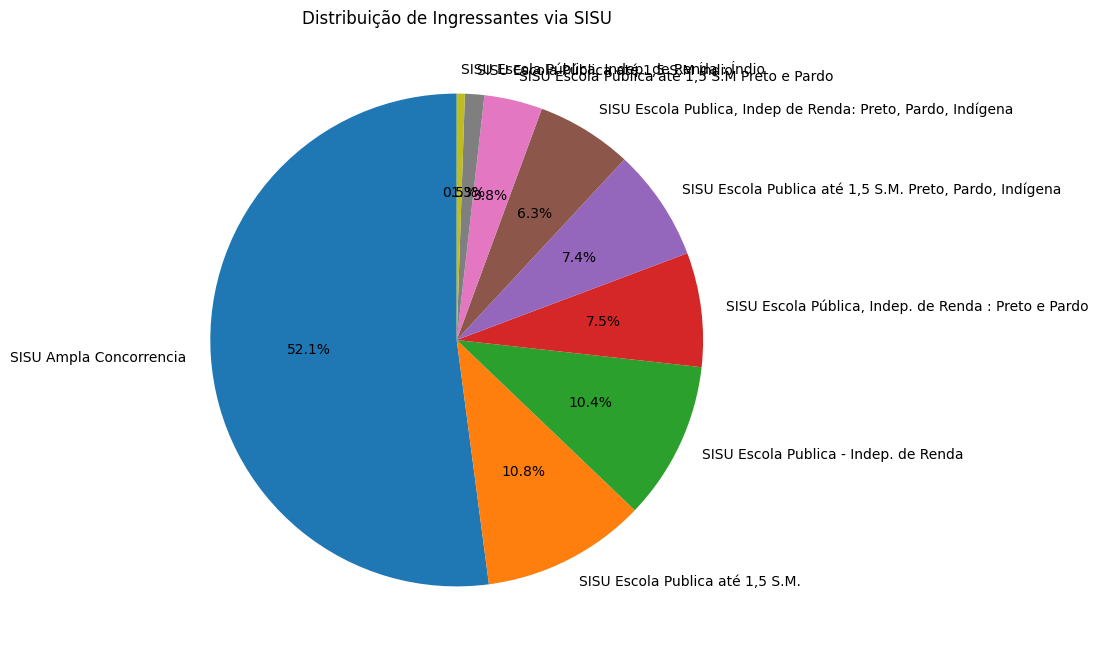

In [ ]:
# prompt: Faça um gráfico de pizza de data_cr['DESCR_FORMA_INGRESSO'] de valores que  startswith('SISU')

# Filtrar os valores que começam com 'SISU'
sisu_values = data_cr[data_cr['DESCR_FORMA_INGRESSO'].str.startswith('SISU', na=False)]['DESCR_FORMA_INGRESSO']

# Contar a frequência de cada valor
sisu_counts = sisu_values.value_counts()

# Criar o gráfico de pizza
plt.figure(figsize=(8, 8))
plt.pie(sisu_counts, labels=sisu_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribuição de Ingressantes via SISU')
plt.show()


In [ ]:
data_cr['renda'] = data_cr['DESCR_FORMA_INGRESSO'].apply(lambda x: 'baixa-renda' if x.startswith('SISU Escola Pública até 1,5 S.M') else 'não-baixa-renda')

In [ ]:
data_cr['ingresso_atual'] = data_cr['DESCR_FORMA_INGRESSO'].apply(lambda x: 'nao-cotistas' if x == 'SISU Ampla Concorrencia' else
                                                         'cotistas' if x.startswith('SISU') else 'antes do SISU')

In [ ]:
data_cr

,ID_PESSOA,NOME_PESSOA,ID_ALUNO,MATR_ALUNO,NUM_VERSAO,NOME_CURSO,COD_CURSO,ID_VERSAO_CURSO,ANO,COD_ATIV_CURRIC,...,GPA3,GPA4,year4,grade_programming1,grade_calculus0,grade_calculus1,grade_linear_algebra,grade_eng_introduction,renda,ingresso_atual
0,56409,Alberto Gomes da Silva,52777,20101220001,2010-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,420,2010,TME0007,...,NaN,NaN,2011.0,0.0,0.0,7.7,0.0,NaN,não-baixa-renda,antes do SISU
1,56409,Alberto Gomes da Silva,52777,20101220001,2010-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,420,2010,TEP0001,...,NaN,NaN,2011.0,0.0,0.0,7.7,0.0,NaN,não-baixa-renda,antes do SISU
2,56409,Alberto Gomes da Silva,52777,20101220001,2010-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,420,2010,TEP0045,...,NaN,NaN,2011.0,0.0,0.0,7.7,0.0,NaN,não-baixa-renda,antes do SISU
3,56409,Alberto Gomes da Silva,52777,20101220001,2010-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,420,2010,HFC0016,...,NaN,NaN,2011.0,0.0,0.0,7.7,0.0,NaN,não-baixa-renda,antes do SISU
4,56409,Alberto Gomes da Silva,52777,20101220001,2010-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,420,2010,TEP0006,...,NaN,NaN,2011.0,0.0,0.0,7.7,0.0,NaN,não-baixa-renda,antes do SISU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24829,170072,PATRICIA FRANCO PEREIRA,145366,20232220019,2018-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,658,2023,SCN0135,...,NaN,NaN,NaN,0.0,0.0,7.7,0.0,NaN,não-baixa-renda,nao-cotistas
24830,170072,PATRICIA FRANCO PEREIRA,145366,20232220019,2018-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,658,2023,SCN0136,...,NaN,NaN,NaN,0.0,0.0,7.7,0.0,NaN,não-baixa-renda,nao-cotistas
24831,169302,IÑIGO GARCIA-MOYA PEREZ,144663,20232220301,2018-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,658,2023,TEP0083,...,NaN,NaN,2024.0,0.0,0.0,7.7,0.0,NaN,não-baixa-renda,antes do SISU
24832,169302,IÑIGO GARCIA-MOYA PEREZ,144663,20232220301,2018-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,658,2023,TEP0078,...,NaN,NaN,2024.0,0.0,0.0,7.7,0.0,NaN,não-baixa-renda,antes do SISU


In [ ]:
data_cr = data_cr[data_cr['ingresso_atual'].isin(['nao-cotistas', 'cotistas'])]
data_cr

,ID_PESSOA,NOME_PESSOA,ID_ALUNO,MATR_ALUNO,NUM_VERSAO,NOME_CURSO,COD_CURSO,ID_VERSAO_CURSO,ANO,COD_ATIV_CURRIC,...,GPA3,GPA4,year4,grade_programming1,grade_calculus0,grade_calculus1,grade_linear_algebra,grade_eng_introduction,renda,ingresso_atual
2098,62747,Paula Simone Gueiros Vilaça,59039,20102220019,2010-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,420,2010,TME0007,...,9.08,8.2,2013.0,0.0,0.0,7.7,0.0,NaN,não-baixa-renda,nao-cotistas
2099,62747,Paula Simone Gueiros Vilaça,59039,20102220019,2010-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,420,2010,TEP0001,...,9.08,8.2,2013.0,0.0,0.0,7.7,0.0,NaN,não-baixa-renda,nao-cotistas
2100,62747,Paula Simone Gueiros Vilaça,59039,20102220019,2010-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,420,2010,TEP0045,...,9.08,8.2,2013.0,0.0,0.0,7.7,0.0,NaN,não-baixa-renda,nao-cotistas
2101,62747,Paula Simone Gueiros Vilaça,59039,20102220019,2010-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,420,2010,HFC0016,...,9.08,8.2,2013.0,0.0,0.0,7.7,0.0,NaN,não-baixa-renda,nao-cotistas
2102,62747,Paula Simone Gueiros Vilaça,59039,20102220019,2010-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,420,2010,HFC0504,...,9.08,8.2,2013.0,0.0,0.0,7.7,0.0,NaN,não-baixa-renda,nao-cotistas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24826,170072,PATRICIA FRANCO PEREIRA,145366,20232220019,2018-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,658,2023,TEP0006,...,NaN,NaN,NaN,0.0,0.0,7.7,0.0,NaN,não-baixa-renda,nao-cotistas
24827,170072,PATRICIA FRANCO PEREIRA,145366,20232220019,2018-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,658,2023,SCN0138,...,NaN,NaN,NaN,0.0,0.0,7.7,0.0,NaN,não-baixa-renda,nao-cotistas
24828,170072,PATRICIA FRANCO PEREIRA,145366,20232220019,2018-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,658,2023,TIN0201,...,NaN,NaN,NaN,0.0,0.0,7.7,0.0,NaN,não-baixa-renda,nao-cotistas
24829,170072,PATRICIA FRANCO PEREIRA,145366,20232220019,2018-01-01,Engenharia de Produção - Bac.- Hab. Prod. Cult...,220,658,2023,SCN0135,...,NaN,NaN,NaN,0.0,0.0,7.7,0.0,NaN,não-baixa-renda,nao-cotistas


# Lendo evasão

In [ ]:
data_evasao = pd.read_excel("/content/gdrive/My Drive/dados_mestrado/Alunos 14Maio2024.xlsx")

In [ ]:
data_evasao

,ID_PESSOA,NOME_PESSOA,SEXO,DT_NASCIMENTO,FORMA_INGRESSO,FORMA_EVASAO,COD_CURSO,NOME_UNIDADE,MATR_ALUNO,NUM_VERSAO,PERIODO_INGRESSO,DT_EVASAO,PERIODO_EVASAO,CPF_MASCARA
0,108278,Alan Oliveira Rodrigues Ramos,M,1987-07-17 00:00:00,PA - Processo Seletivo - Mestrado,ABA - Abandono do curso,01P2F,Matemática em Rede Nacional - Mestrado Profiss...,15101P2F01,2011-01-01 00:00:00,2015/1°. semestre,2016-03-28 00:00:00,2016/1°. semestre,12057013707
1,138874,Alberto Renan Dias da Silva,M,1992-11-20 00:00:00,PA - Processo Seletivo - Mestrado,CON - Curso concluído,01P2F,Matemática em Rede Nacional - Mestrado Profiss...,19101P2MP01,2011-01-01 00:00:00,2019/1°. semestre,2021-08-12 00:00:00,2021/1°. semestre,14380184790
2,118637,Alcebiades de Calazans Barbosa,M,1971-02-15 00:00:00,PA - Processo Seletivo - Mestrado,CON - Curso concluído,01P2F,Matemática em Rede Nacional - Mestrado Profiss...,16101P2F01,2011-01-01 00:00:00,2016/1°. semestre,2019-02-05 00:00:00,2019/1°. semestre,99431785749
3,138875,Alciley Dias Pereira,M,1963-11-01 00:00:00,PA - Processo Seletivo - Mestrado,DES - Desligamento (curso não concluido),01P2F,Matemática em Rede Nacional - Mestrado Profiss...,19101P2MP02,2011-01-01 00:00:00,2019/1°. semestre,2020-12-23 00:00:00,2020/1°. semestre,75453088753
4,138875,Alciley Dias Pereira,M,1963-11-01 00:00:00,Processo Seletivo Mestrado - Pessoa negra,DES - Desligamento (curso não concluido),01P2F,Matemática em Rede Nacional - Mestrado Profiss...,21101P2MP01,2011-01-01 00:00:00,2021/1°. semestre,2023-05-02 00:00:00,2023/1°. semestre,75453088753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65530,155882,Wilson De Souza Cordeiro,M,1983-04-24 00:00:00,VE - Vestibular,Sem evasão,601BRO,Matemática - Licenciatura a distância - Polo B...,21216010010,2015-02-01 00:00:00,2021/2°. semestre,NaN,NaN,9315158741
65531,145602,Wladimir Pedro Barbosa,M,1962-03-03 00:00:00,VE - Vestibular,CAN - Cancelamento Geral do curso,601BRO,Matemática - Licenciatura a distância - Polo B...,18116010057,2015-02-01 00:00:00,2018/1°. semestre,2023-12-30 00:00:00,2023/2°. semestre,75639246715
65532,145564,Ygor Luis Araujo Da Silva,M,1997-05-26 00:00:00,VE - Vestibular,CAN - Cancelamento Geral do curso,601BRO,Matemática - Licenciatura a distância - Polo B...,17216010155,2015-02-01 00:00:00,2017/2°. semestre,2018-01-01 00:00:00,2018/1°. semestre,17201339729
65533,145488,Ygor Maciel De Abreu,M,1996-04-22 00:00:00,VE - Vestibular,CAN - Cancelamento Geral do curso,601BRO,Matemática - Licenciatura a distância - Polo B...,16216010118,2015-02-01 00:00:00,2016/2°. semestre,2023-12-31 00:00:00,2023/2°. semestre,15808268737


# Tratando o CPF

In [ ]:
# No valor de data_evasao['CPF_TRATADO'] que tiver 10 caracteres, adicione um 0 na frente.
data_evasao['CPF_MASCARA'] = data_evasao['CPF_MASCARA'].astype(str)
for i in range(10, 0, -1):
    data_evasao['CPF_MASCARA'] = np.where(data_evasao['CPF_MASCARA'].str.len() == i, '0' * (11 - i) + data_evasao['CPF_MASCARA'], data_evasao['CPF_MASCARA'])

In [ ]:
# Função para substituir os caracteres
def tratar_cpf(cpf):
    return '***' + cpf[3:-2] + '**'

# Aplicando a função na coluna CPF_MASCARA e criando a coluna CPF_TRATADO
data_evasao['CPF_TRATADO'] = data_evasao['CPF_MASCARA'].apply(tratar_cpf)


In [ ]:
data_evasao

,ID_PESSOA,NOME_PESSOA,SEXO,DT_NASCIMENTO,FORMA_INGRESSO,FORMA_EVASAO,COD_CURSO,NOME_UNIDADE,MATR_ALUNO,NUM_VERSAO,PERIODO_INGRESSO,DT_EVASAO,PERIODO_EVASAO,CPF_MASCARA,CPF_TRATADO
0,108278,Alan Oliveira Rodrigues Ramos,M,1987-07-17 00:00:00,PA - Processo Seletivo - Mestrado,ABA - Abandono do curso,01P2F,Matemática em Rede Nacional - Mestrado Profiss...,15101P2F01,2011-01-01 00:00:00,2015/1°. semestre,2016-03-28 00:00:00,2016/1°. semestre,12057013707,***570137**
1,138874,Alberto Renan Dias da Silva,M,1992-11-20 00:00:00,PA - Processo Seletivo - Mestrado,CON - Curso concluído,01P2F,Matemática em Rede Nacional - Mestrado Profiss...,19101P2MP01,2011-01-01 00:00:00,2019/1°. semestre,2021-08-12 00:00:00,2021/1°. semestre,14380184790,***801847**
2,118637,Alcebiades de Calazans Barbosa,M,1971-02-15 00:00:00,PA - Processo Seletivo - Mestrado,CON - Curso concluído,01P2F,Matemática em Rede Nacional - Mestrado Profiss...,16101P2F01,2011-01-01 00:00:00,2016/1°. semestre,2019-02-05 00:00:00,2019/1°. semestre,99431785749,***317857**
3,138875,Alciley Dias Pereira,M,1963-11-01 00:00:00,PA - Processo Seletivo - Mestrado,DES - Desligamento (curso não concluido),01P2F,Matemática em Rede Nacional - Mestrado Profiss...,19101P2MP02,2011-01-01 00:00:00,2019/1°. semestre,2020-12-23 00:00:00,2020/1°. semestre,75453088753,***530887**
4,138875,Alciley Dias Pereira,M,1963-11-01 00:00:00,Processo Seletivo Mestrado - Pessoa negra,DES - Desligamento (curso não concluido),01P2F,Matemática em Rede Nacional - Mestrado Profiss...,21101P2MP01,2011-01-01 00:00:00,2021/1°. semestre,2023-05-02 00:00:00,2023/1°. semestre,75453088753,***530887**
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65530,155882,Wilson De Souza Cordeiro,M,1983-04-24 00:00:00,VE - Vestibular,Sem evasão,601BRO,Matemática - Licenciatura a distância - Polo B...,21216010010,2015-02-01 00:00:00,2021/2°. semestre,NaN,NaN,09315158741,***151587**
65531,145602,Wladimir Pedro Barbosa,M,1962-03-03 00:00:00,VE - Vestibular,CAN - Cancelamento Geral do curso,601BRO,Matemática - Licenciatura a distância - Polo B...,18116010057,2015-02-01 00:00:00,2018/1°. semestre,2023-12-30 00:00:00,2023/2°. semestre,75639246715,***392467**
65532,145564,Ygor Luis Araujo Da Silva,M,1997-05-26 00:00:00,VE - Vestibular,CAN - Cancelamento Geral do curso,601BRO,Matemática - Licenciatura a distância - Polo B...,17216010155,2015-02-01 00:00:00,2017/2°. semestre,2018-01-01 00:00:00,2018/1°. semestre,17201339729,***013397**
65533,145488,Ygor Maciel De Abreu,M,1996-04-22 00:00:00,VE - Vestibular,CAN - Cancelamento Geral do curso,601BRO,Matemática - Licenciatura a distância - Polo B...,16216010118,2015-02-01 00:00:00,2016/2°. semestre,2023-12-31 00:00:00,2023/2°. semestre,15808268737,***082687**


# Tratando a evasão

In [ ]:
# prompt: Liste todos os valores únicos de data_evasao['FORMA_EVASAO']

print(data_evasao['FORMA_EVASAO'].unique())


['ABA - Abandono do curso' 'CON - Curso concluído'
 'DES - Desligamento (curso não concluido)'
 'CAN - Cancelamento Geral do curso' 'Sem evasão'
 'DES - Desistência (pós graduação)' 'JUB - Jubilamento'
 'APO - Aluno Especial - Disciplina Isolada' 'Desistência SiSU'
 'MST - Mudança de nível sem titulação (pós-graduação)'
 'TIC - Transferência Interna' 'FAL - Falecimento do discente'
 'Passagem Direta - Pós-Graduação' 'TTU - Transferência de Turno'
 'Não identificada (vide pasta do aluno)' 'Reopção de Curso'
 'TNE - Transferido para outa Instituição'
 'APO - Apostilamento - Conclusão de Habilitação' 'Aprovado'
 'APO -Conclusão da Mobilidade Acadêmica Externa - IAE/IESCE'
 'APO -Conclusão a Mobilidade Acadêmica Externa - ANDIFES'
 'MCT - Mudança de nível com titulação (pós-graduação)']


In [ ]:
# prompt: Substitua os valores de data_evasao['FORMA_EVASAO'] que sejam 'CON - Curso concluído' por 'Concluido'

data_evasao['FORMA_EVASAO'] = data_evasao['FORMA_EVASAO'].replace('CON - Curso concluído', 'Concluido')


In [ ]:
# prompt: Substitua os valores de data_evasao['FORMA_EVASAO'] que sejam 'ABA - Abandono do curso' ou 'DES - Desligamento (curso não concluido)' ou 'CAN - Cancelamento Geral do curso' ou 'DES - Desistência (pós graduação)' ou 'JUB - Jubilamento' por 'Evadido'

data_evasao['FORMA_EVASAO'] = data_evasao['FORMA_EVASAO'].replace(['ABA - Abandono do curso', 'DES - Desligamento (curso não concluido)', 'CAN - Cancelamento Geral do curso', 'DES - Desistência (pós graduação)', 'JUB - Jubilamento'], 'Evadido')


In [ ]:
# prompt: Tire as linhas de data_evasao cujos os valores não sejam 'Concluido' ou 'Evadido'

data_evasao = data_evasao[data_evasao['FORMA_EVASAO'].isin(['Concluido', 'Evadido'])]


In [ ]:
data_evasao

,ID_PESSOA,NOME_PESSOA,SEXO,DT_NASCIMENTO,FORMA_INGRESSO,FORMA_EVASAO,COD_CURSO,NOME_UNIDADE,MATR_ALUNO,NUM_VERSAO,PERIODO_INGRESSO,DT_EVASAO,PERIODO_EVASAO,CPF_MASCARA,CPF_TRATADO
0,108278,Alan Oliveira Rodrigues Ramos,M,1987-07-17 00:00:00,PA - Processo Seletivo - Mestrado,Evadido,01P2F,Matemática em Rede Nacional - Mestrado Profiss...,15101P2F01,2011-01-01 00:00:00,2015/1°. semestre,2016-03-28 00:00:00,2016/1°. semestre,12057013707,***570137**
1,138874,Alberto Renan Dias da Silva,M,1992-11-20 00:00:00,PA - Processo Seletivo - Mestrado,Concluido,01P2F,Matemática em Rede Nacional - Mestrado Profiss...,19101P2MP01,2011-01-01 00:00:00,2019/1°. semestre,2021-08-12 00:00:00,2021/1°. semestre,14380184790,***801847**
2,118637,Alcebiades de Calazans Barbosa,M,1971-02-15 00:00:00,PA - Processo Seletivo - Mestrado,Concluido,01P2F,Matemática em Rede Nacional - Mestrado Profiss...,16101P2F01,2011-01-01 00:00:00,2016/1°. semestre,2019-02-05 00:00:00,2019/1°. semestre,99431785749,***317857**
3,138875,Alciley Dias Pereira,M,1963-11-01 00:00:00,PA - Processo Seletivo - Mestrado,Evadido,01P2F,Matemática em Rede Nacional - Mestrado Profiss...,19101P2MP02,2011-01-01 00:00:00,2019/1°. semestre,2020-12-23 00:00:00,2020/1°. semestre,75453088753,***530887**
4,138875,Alciley Dias Pereira,M,1963-11-01 00:00:00,Processo Seletivo Mestrado - Pessoa negra,Evadido,01P2F,Matemática em Rede Nacional - Mestrado Profiss...,21101P2MP01,2011-01-01 00:00:00,2021/1°. semestre,2023-05-02 00:00:00,2023/1°. semestre,75453088753,***530887**
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65529,145487,Wilma Gomes De Lima,F,1966-03-28 00:00:00,VE - Vestibular,Evadido,601BRO,Matemática - Licenciatura a distância - Polo B...,16216010006,2015-02-01 00:00:00,2016/2°. semestre,2019-01-01 00:00:00,2019/1°. semestre,88418430710,***184307**
65531,145602,Wladimir Pedro Barbosa,M,1962-03-03 00:00:00,VE - Vestibular,Evadido,601BRO,Matemática - Licenciatura a distância - Polo B...,18116010057,2015-02-01 00:00:00,2018/1°. semestre,2023-12-30 00:00:00,2023/2°. semestre,75639246715,***392467**
65532,145564,Ygor Luis Araujo Da Silva,M,1997-05-26 00:00:00,VE - Vestibular,Evadido,601BRO,Matemática - Licenciatura a distância - Polo B...,17216010155,2015-02-01 00:00:00,2017/2°. semestre,2018-01-01 00:00:00,2018/1°. semestre,17201339729,***013397**
65533,145488,Ygor Maciel De Abreu,M,1996-04-22 00:00:00,VE - Vestibular,Evadido,601BRO,Matemática - Licenciatura a distância - Polo B...,16216010118,2015-02-01 00:00:00,2016/2°. semestre,2023-12-31 00:00:00,2023/2°. semestre,15808268737,***082687**


# Juntando os dois bancos de dados

In [ ]:
if data_cr["NOME_CURSO"].iloc[0] == "Sistemas de Informação - Bacharelado - Turno Integral (V/N)":
  data_unificado = pd.merge(
      data_cr[['renda','NOME_PESSOA', 'ANO_EVASAO', 'ingresso_atual', 'NOME_CURSO', 'NOME_ATIV_CURRIC', 'MEDIA_FINAL', 'SEXO' , 'DESCR_SITUACAO', 'ANO_INGRESSO', 'ANO', 'CR_NO_PERIODO', 'CR_ATUAL','GPA1', 'GPA2', 'GPA3', 'GPA4', 'year4','grade_programming1', 'grade_programming2', 'grade_basic_math','grade_calculus1', 'grade_linear_algebra', "grade_logic"]],
      data_evasao[['NOME_PESSOA', 'FORMA_EVASAO', 'CPF_TRATADO' ,'CPF_MASCARA', 'DT_EVASAO']],
      on='NOME_PESSOA',
      how='inner'
  )
  data_unificado

In [1]:
if data_cr["NOME_CURSO"].iloc[0] == "Matemática - Licenciatura - Turno Integral (Vepsertino/Noturno)":
  data_unificado = pd.merge(
      data_cr[['renda','NOME_PESSOA', 'ANO_EVASAO', 'ingresso_atual', 'NOME_CURSO', 'NOME_ATIV_CURRIC', 'MEDIA_FINAL', 'SEXO' , 'DESCR_SITUACAO', 'ANO_INGRESSO', 'ANO', 'CR_NO_PERIODO', 'CR_ATUAL','GPA1', 'GPA2', 'GPA3', 'GPA4', 'year4','grade_programming1', 'grade_geometry1', 'grade_math_foundation','grade_calculus1', 'grade_analytic_geometry', "grade_enviroment"]],
      data_evasao[['NOME_PESSOA', 'FORMA_EVASAO', 'CPF_TRATADO' ,'CPF_MASCARA', 'DT_EVASAO']],
      on='NOME_PESSOA',
      how='inner'
  )
  data_unificado

NameError: name 'data_cr' is not defined

In [ ]:
if data_cr["NOME_CURSO"].iloc[0] == "Engenharia de Produção - Bac.- Hab. Prod. Cultura - Turno Noturno":
  data_unificado = pd.merge(
      data_cr[['renda','NOME_PESSOA', 'ANO_EVASAO', 'ingresso_atual', 'NOME_CURSO', 'NOME_ATIV_CURRIC', 'MEDIA_FINAL', 'SEXO' , 'DESCR_SITUACAO', 'ANO_INGRESSO', 'ANO', 'CR_NO_PERIODO', 'CR_ATUAL','GPA1', 'GPA2', 'GPA3', 'GPA4', 'year4','grade_programming1', 'grade_calculus0','grade_calculus1', 'grade_linear_algebra', "grade_eng_introduction"]],
      data_evasao[['NOME_PESSOA', 'FORMA_EVASAO', 'CPF_TRATADO' ,'CPF_MASCARA', 'DT_EVASAO']],
      on='NOME_PESSOA',
      how='inner'
  )
  data_unificado

In [ ]:
# prompt: Coloque todos os valores de NOME_PESSOA em caixa alta

data_unificado['NOME_PESSOA'] = data_unificado['NOME_PESSOA'].str.upper()


In [ ]:
# prompt: Faça o download de data_unificado em formato xlsx
file_name = file_name+"_1.xlsx"
data_unificado.to_excel("/content/gdrive/My Drive/dados_mestrado/"+file_name)
